# Dataset Preparation

## Loading Dependencies

#### Dependencies used:
- Standard Utility Modules (os, struct, time, urllib, gzip)
- Core 3rd Party packeges (numpy, matplotlib)


In [1]:
# Python Standard Libraries
# import os
import os.path #for accessing the file path
import struct  #for unpacking the binary data

import time    #for calculating time

from urllib.request import urlopen #for downloading the dataset
from urllib.error import URLError, HTTPError #for error handling while downloading data

import gzip as unzip #for decompressing the downloaded dataset

#core packages
import numpy as np #for mathematical calculations
import matplotlib.pyplot as plt #for visualization

%matplotlib inline

## Downloading Dataset

- Download MNIST dataset form its official site
> http://yann.lecun.com/exdb/mnist/index.html

- Download  fashion-MNIST dataset form its official site
    >https://github.com/zalandoresearch/fashion-mnist
<br>
Paper: https://arxiv.org/pdf/1708.07747.pdf 

Fashion MNIST dataset is not a part of this project. It is, however, used to evaluate the algorithms implemented and as a comparision metric for the performance in MNIST dataset

In [2]:
#help from  https://gist.github.com/kissgyorgy/6102803 for bufferring part
def download_dataset(dataset, to_path):
    """Downloads the dataset form the original data source.
        
        Arguments:
            dataset (str): Dataset used, mnist or fashion_mnist.
            to_path (str): Path of the directory where the dataset is to be downloaded.
        
        Example:
            >>> download_dataset(dataset = "fashion_mnist", to_path = "dataset/fashion_mnist/")
        
        References:
            https://gist.github.com/kissgyorgy/6102803 (Buffering Part)
    """
    
    #defining the source urls for data download
    if dataset == "mnist":
        urls = ["http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
                "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"] 
    
    elif dataset == "fashion_mnist":
        urls = ["http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz",
                "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz", 
                "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz",
                "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz" ] 
    else:
        raise ValueError("Only 'mnist' and 'fashion_mnist' dataset are supported")
    
    path = to_path #destination path
    
    #checking the path for data download and creating the required directories if not found
    if not os.path.exists(path):
        print("Destination directory does not exist: Creating '" + path + "' as a new directory.\n")
        os.makedirs(path) #creating required directories recursively
#         if this is to be handled form load_dataset() method the following lines of code should be used instead of the above two lines
#         print("Directory not found: It should be handled from the load_dataset(parent) module")
#         return
    
    download_status = "succeeded" #initializing download status
    
    #downloading the data files for each url
    for url in urls: 
        filename = url.split('/')[-1] #getting the filename from the url
        
        #downloading the file if it does not exist
        if not os.path.exists(path + filename):
            print("\n%s: downloading..."%filename)
            try:  
                
                #urlretrive() can also be used to obtain data directly.. this method with buffer is used to show the download progress
                data_online = urlopen(url) 
                
                #opening a new file of the same filename and writing the content of the url in the file
                with open(path + filename, 'wb') as data_local:
                    file_size = int(data_online.info()["Content-Length"]) #getting the file size of the file from the url
                    file_size_mb = file_size/(1024*1024) #for linux system use 1000 instead of 1024
                    downloaded_file_size = 0
                    block_size = 1024 #setting the block size to read the data from the url
                    while True:
                        buffer = data_online.read(block_size) #bufferring the file content
                        if not buffer:
                            break #breaking if no data left to read form the url
                        downloaded_file_size += len(buffer) #adding up downloaded file size
                        downloaded_file_size_mb = downloaded_file_size/(1024*1024) #converting file size to MB from bytes
                        data_local.write(buffer) #writing in the opened file in the local machine
                        
                        #calculating the downloaded percentage of the file
                        down_percent = downloaded_file_size * 100. / file_size
                        inc = int(down_percent)//10 #calculating the increment of the progress bar
                        print ("%.3f MB  [%.3f MB done %s>%s %.0f%%]" %( file_size_mb, downloaded_file_size_mb, '=' * inc,'.'*(10-inc), down_percent), end = "\r")
            except HTTPError as error_message:
                print('Download Failed: ', error_message)
                download_status = "failed"
            except URLError as error_message:
                print('Download Failed: ', error_message)
                download_status = "failed"
        else:
            print("\n%s: already exists."%filename)
    print("\n\nDataset download %s...\n"%download_status)

In [3]:
download_dataset(dataset ="fashion_mnist" , to_path = "dataset/fashion_mnist/")


train-images-idx3-ubyte.gz: already exists.

train-labels-idx1-ubyte.gz: already exists.

t10k-images-idx3-ubyte.gz: already exists.

t10k-labels-idx1-ubyte.gz: already exists.


Dataset download succeeded...



## Decompressing the gzip Dataset files to the desired binary files

In [4]:
# https://www.tutorialspoint.com/working-with-zip-files-in-python
# https://www.geeksforgeeks.org/os-walk-python/


def is_gzip(filename):
    """Check if the file si gzip or not.
        
        Argument:
            filename (str): file to be checked.
        
        Return:
            Bool: True if the given file is gzip, false otherwise.
        
        Example:
            >>> is_gzip(filename)
    """
    #checking the extention of the file to determine if it is a gzip file or not
    ext = filename.split(".")[-1]
    if ext == "gz":
        return True

def get_files(path,file_type = "all"):
    """Get all the files of file_type form the given path.
        
        Arguments:
            path (str): location where the files are to be checked.
            file_type (str,optional) : type of files to be checked. Defaults to "all".
       
        Return:
            files (list): name of the files in the given path
        
        Example:
            >>> files = get_files(path, file_type = "all")
    """
    files = []
    #accessing all files in the supplied path
    for root, dirs, file in os.walk(path):
        for fname in file:
            if file_type == "gzip": #if only gzip files are to be returned
                if is_gzip(fname): #checking if the file is gzip
                    files.append(fname)
            else:
                files.append(fname) #if all files are to be returned
    return files
      

    
def decompress_dataset(path, keep_original = True):
    """Decompress the gzip files in the given path.
        
        Arguments:
            path (str): location of the file to be decompressed.
            keep_original (bool, optional): Keep the gzip file after decompressionif True, remove otherwise. Defaults to True.
        
        Example:
            >>> decompress_dataset(path = "dataset/fashion_mnist/")            
    """
    files = get_files(path, file_type = "gzip")
    
    #checking if there are any gzip file to decompress
    if len(files) == 0:
        print("No gzip file to decompress.")
        return
    
    for filename in files:
        try:
            with open(path + filename.split(".")[0],'wb') as fp: #opening a file on which the gzip file content is to be written
                with unzip.open(path + filename, 'rb') as fzip: #opening the gzip file to be decompressed
                    file_data = fzip.read() #reading the gzip file
                fp.write(file_data) #writing the read content to another local file
            if keep_original == False:
                os.remove(path+filename) #removing the gzip file after decompression
        except unzip.BadZipFile:
            print('Error: Invalid gzip file encountered.')
    
    print("Dataset decompression succeeded...")
    if keep_original == False:
        print("Original gzip files removed...")



In [5]:
decompress_dataset(path = "dataset/fashion_mnist/")

Dataset decompression succeeded...


## Retriving data from binary file

In [6]:
def retrive_dataset(path, filename):
    """Retrive mnist or fashion_mnist dataset from  the binary file into numpy arrays.        
        
        Arguments:
            path (str): path where the files are located
            filename (str): name of the files that are to be retrived
        
        Returns:
            train_images (numpy.ndarray) : 3D array consisting of m examples of training images 
            train_labels (numpy.ndarray) : labels for each training images
            test_images (numpy.ndarray) : 3D array consisting of m examples of test images 
            test-labels (numpy.ndarray) : labels for each test images
        
        Example:
            >>> train_x, train_y, test_x, test_y = retrive_dataset(path, filename)
            
        References:
            mnist (str/url): http://yann.lecun.com/exdb/mnist/
            fashion_mnist (str/url): https://github.com/zalandoresearch/fashion-mnist/
            Code for Retrival(str\retrival): https://www.cs.virginia.edu/~connelly/class/2015/large_scale/proj2/mnist_python
                modified to our need making data retrival 8-10 times faster
    """
    #setting file path based on the dataset
    train_img_file_path = path + filename[0]
    train_lbl_file_path = path + filename[1]
    test_img_file_path = path + filename[2]
    test_lbl_file_path = path + filename[3]
     
    #retriving the training data
    with open(train_img_file_path, 'rb') as train_fimg, open(train_lbl_file_path, 'rb') as train_flbl :
        #retriving labels
        _, size = struct.unpack(">II", train_flbl.read(8))
        train_labels = np.frombuffer(train_flbl.read(), dtype=np.int8).reshape(size,1)
        #retriving images
        _, _, rows, cols = struct.unpack(">IIII", train_fimg.read(16))
        train_images = np.frombuffer(train_fimg.read(),dtype=np.uint8).reshape(size, rows, cols)
       
    #retriving the test data
    with open(test_img_file_path, 'rb') as test_fimg, open(test_lbl_file_path, 'rb') as test_flbl :
        #retriving labels
        _, size = struct.unpack(">II", test_flbl.read(8))
        test_labels = np.frombuffer(test_flbl.read(), dtype=np.int8).reshape(size,1)
        #retriving images
        _, _, rows, cols = struct.unpack(">IIII", test_fimg.read(16))
        test_images = np.frombuffer(test_fimg.read(),dtype=np.uint8).reshape(size, rows, cols)
     
    #validating the shape of the retrived data
    assert(train_images.shape == (60000, 28, 28))
    assert(train_labels.shape == (60000,1))
    assert(test_images.shape == (10000, 28, 28))
    assert(test_labels.shape == (10000,1))
    
  
    
    return train_images, train_labels, test_images, test_labels



In [7]:
path = "dataset/fashion_mnist/"
    
filename = ["train-images-idx3-ubyte",
            "train-labels-idx1-ubyte",
            "t10k-images-idx3-ubyte",
            "t10k-labels-idx1-ubyte"] 
#retriving the data
train_x_orig, train_y_orig, test_x_temp, test_y_temp = retrive_dataset(path, filename)

#displaying the retrival info
print("Data\t\t\t","Datatype\t\t","Shape")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_temp))+"\t",str(test_x_temp.shape))
print("Test Set Labels:\t" + str(type(test_y_temp))+"\t",str(test_y_temp.shape))
print("=================================================================")


Data			 Datatype		 Shape
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (10000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (10000, 1)


## Sample a portion of the retrived Dataset

In [8]:
#retriving a small sample of the original dataset for model development and experimentation
def sample_dataset(x,y, size_in_per):
    """Returns a sample dataset from the original larger dataset
       
        Arguments:
            x (numpy.ndarray): original input data
            y (numpy.ndarray): original output labels
            size_in_per (int): sample volume in percentage
        
        Returns:
            x_sample (numpy.ndarray): input sample  from original dataset of size (sample_size% of x)
            y_sample (numpy.ndarray): output sample  from original dataset of size (sample_size% of y)
            
        Example:
            >>> train_x_sample, train_y_sample = sample_dataset(train_x,train_y, size_in_per = 100)
    """
    m = y.shape[0]
    
    #getting the sample size to be returned from the percentage
    sample_m = int(np.multiply(m,np.divide(size_in_per,100))) #int(m*(dataVol/100)) 
    
    #suffling the original dataset
    randCol = np.random.permutation(m)
    x_suffled = x[randCol,:,:]
    y_suffled = y[randCol,:]
    
    #taking samples of sample_size
    x_sample = x_suffled[0:sample_m,:,:]
    y_sample = y_suffled[0:sample_m,:]
    
    #vallidating the sample data size
    assert(x_sample.shape == (sample_m,28,28))
    assert(y_sample.shape == (sample_m,1))

    return x_sample, y_sample

## Load the dataset

In [9]:
def load_dataset(dataset, size_in_per = 100):
    """Loads the dataset from its raw form to an nd-array representation.
        
        Arguments:
            dataset (str): dataset used, mnist or fashion_mnist
            size_in_per (int, optional): size of the sample to be drawn from the dataset. Defaults to 100
        
        Returns:
            train_x_orig (numpy.ndarray): training set images of size (6000,28,28) 
            train_y_orig (numpy.ndarray): training set labels of size (60000,1)
            test_x_orig (numpy.ndarray): test set images of size (10000,28,28)
            test_y_orig (numpy.ndarray): test set labels of size (10000,1)
        
        Example:
            >>> train_x, train_y, test_x, test_y = load_dataset(dataset = "fashion_mnist", size_in_per = 25)
    """
    
    path = 'dataset/%s/'%(dataset) #generating the dataset path
     
    filename = ["train-images-idx3-ubyte",
                "train-labels-idx1-ubyte",
                "t10k-images-idx3-ubyte",
                "t10k-labels-idx1-ubyte"] 
    gzip_filename = [fname+".gz" for fname in filename] #generating the gzip file name

    
    #creating a new destination path if it doesnot exist
    if not os.path.exists(path):
        print("No destination directory exists to load the data from:\nCreating '" + path + "' as a new directory...\n")
        os.makedirs(path) #making directories recursively
    
    #Downloading the dataset form  the web if the path is empty (i.e if no dataset is found in the specified directory)
    if len(get_files(path)) == 0:
        print ("Downloading the %s dataset..."%dataset)
        download_dataset(dataset, to_path = path)
    
    files = get_files(path) #getting all the files in the path after download
    
    #checking for all the decompressed files
    file_check = all(fname in files for fname in filename)  

    #implementating the logic for data retrival form the specified path
    if file_check == False:       
        gzip_filecheck = all(fname in files for fname in gzip_filename) #checking for all the gzip files
        if gzip_filecheck == False:
            print ("Downloading missing gzip files of %s dataset..."%dataset)
            download_dataset(dataset, to_path = path) #downloading missing zip file of the dataset
        print ("Decompressing the %s dataset..."%dataset)
        decompress_dataset(path,keep_original = True)#decompressing the dataset
    
    train_x_temp, train_y_temp, test_x_temp, test_y_temp = retrive_dataset(path, filename)
    
    #getting the size of the data based on the sample size
    #size = 100 means entire data is suffled and returned
    train_x_orig, train_y_orig = sample_dataset(train_x_temp,train_y_temp, size_in_per)
    test_x_orig, test_y_orig = sample_dataset(test_x_temp,test_y_temp, size_in_per)
    

    return train_x_orig, train_y_orig, test_x_orig, test_y_orig
        

In [10]:
dataset_size_in_per = 100

toc = time.time()
train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

tic = time.time()
#displaying the retrival info
print("\nTime to load data from binary file using numpy: %.4f s\n"%(tic-toc))

print("Sample Size : %d%%\n"%(dataset_size_in_per))

print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



Time to load data from binary file using numpy: 0.0797 s

Sample Size : 100%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (10000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (10000, 1)


## Train-Dev split

In [11]:
def train_dev_split(train_x,train_y):
    """Randomly splits the test set to dev and test set
        
        Arguments:
            train_x (numpy.ndarray): train set images of size (60000,28,28), where m is num of examples in train_x
            train_y (numpy.ndarray): train set labels of size (60000,1)
        
        Returns:
            train_x_split (numpy.ndarray): train set images of size (50000,28,28) , where n is num of examples in dev_x
            train_y_split (numpy.ndarray): train set labels of size (50000,1)
            dev_x_split (numpy.ndarray): dev set images of size (10000,28,28)
            dev_y_split (numpy.ndarray): dev set labels of size (10000,1)
        
        Example:
            >>> train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x, train_y)
    """
    m = train_y.shape[0]
    n = 50000 #Splitting the training set into train and dev set of size 50000 and 10000 respectively
    #suffling the test dataset
    randCol = np.random.permutation(m)
    suffled_x = train_x[randCol,:,:]
    suffled_y = train_y[randCol,:]
    
    #splitting the test set into dev and test set , 50% each
    train_x_split = suffled_x[0:n,:,:]
    train_y_split = suffled_y[0:n,:]
    
    dev_x_split = suffled_x[n:m,:,:]
    dev_y_split = suffled_y[n:m,:]
    
    assert(train_x_split.shape == (n,28,28))
    assert(train_y_split.shape == (n,1))
    assert(dev_x_split.shape == (m-n,28,28))
    assert(dev_y_split.shape == (m-n,1))
    
    return train_x_split, train_y_split, dev_x_split, dev_y_split 

In [12]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (50000, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (50000, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (10000, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (10000, 1)


## Visualizing and Validating Raw datasets

In [13]:
#dataset visualization using charts
def visualize_data_distribution(y_orig, dataset_type):
    """Plots bar graph showing the distribution of examples in each class

        Arguments:
            y_orig (numpy.ndarray): labels of dev set
            dataset_type(str): type of dataset, can be training, dev or test
            
        Example:
            >>> visualize_data_distribution(train_y, dataset_type = "training")            
    """
    #setting the plot style
#     plt.style.use('seaborn')
    
    #creating subplots
    fig, axes = plt.subplots(figsize=(10,5))
    i = 0
    
    #plotting the bar graph for each dataset labels
    unique, counts = np.unique(y_orig, return_counts=True) 
    axes.bar(unique, counts)
    max_value = np.max(counts)
    axes.set(xticks = unique, ylim = (0,max_value + max_value // 10))
    axes.set_title("Distribution of Examples in %s Set"%dataset_type.capitalize() , fontsize = 16)
    axes.set_xlabel("Classes", fontsize = 12)
    axes.set_ylabel("Number of Examples", fontsize = 12)

    i += 1

    plt.show()

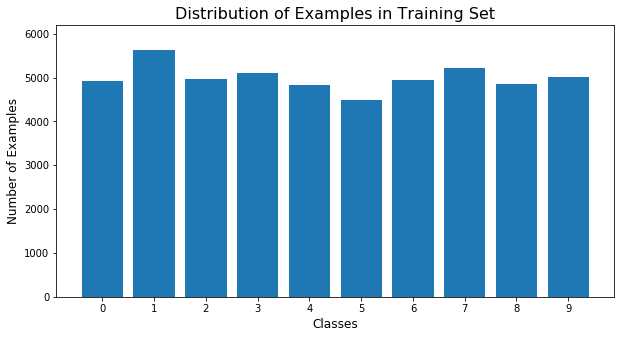

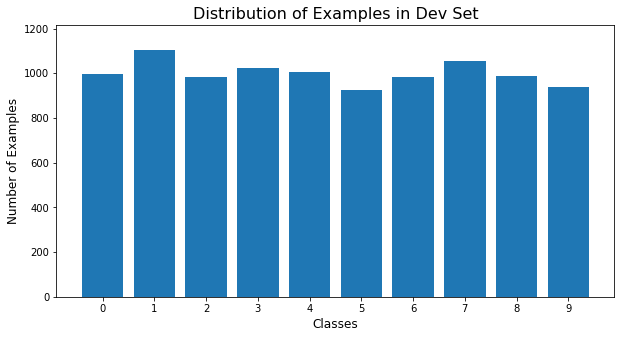

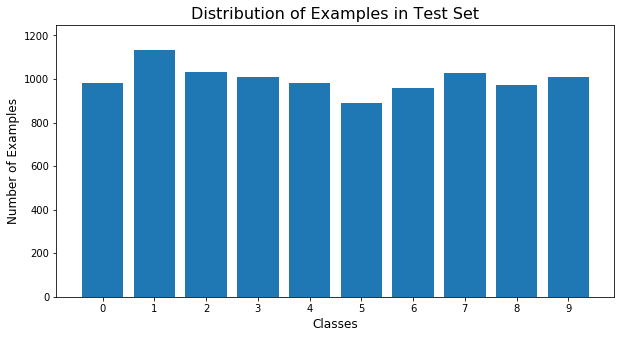

In [14]:
visualize_data_distribution(train_y_split, dataset_type = "training")
visualize_data_distribution(dev_y_split,  dataset_type = "dev")
visualize_data_distribution(test_y_orig,  dataset_type = "test")

In [15]:
def label_description(dataset):
    """Returns the description of the labels
        
        Arguments:
            dataset(str): dataset used, mnist of fashion_mnist

        Return:
            desc (dict): label description
        
        Example:
            >>> label_desc = label_description(dataset = "fashion_mnist")
    """
    
    #creating the label description for fashion_mnist dataset
    if dataset == "fashion_mnist":
        desc = {0:"T-shirt/top",
                1:"Trouser",
                2:"Pullover",
                3:"Dress",
                4:"Coat",
                5:"Sandal",
                6:"Shirt",
                7:"Sneaker",
                8:"Bag",
                9:"Ankle boot"}
    #creating the label description for mnist dataset
    elif dataset == "mnist":
        desc = {0:"Zero",
                1:"One",
                2:"Two",
                3:"Three",
                4:"Four",
                5:"Five",
                6:"Six",
                7:"Seven",
                8:"Eight",
                9:"Nine"}
    else:
        raise ValueError("Dataset must be mnist or fashion_mnist")
        
    return desc


Text(0.5, 1.0, ' Label: 1 | One')

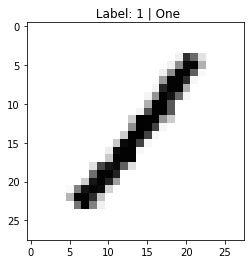

In [16]:
label_desc = label_description(dataset = "mnist")

plt.imshow(test_x_orig[200], cmap = "Greys")
a = int(test_y_orig[200])
plt.title(" Label: %d | %s"%(a,label_desc[a]))
# print(255-test_x_orig[2])

In [17]:
def visualize_dataset(x_orig, y_orig, dataset, dataset_type):
    """Plots 10 sample images  with labels and label description
        
        Arguments:
            x_orig (numpy.ndarray): 3D array representation of input images
            y_orig (numpy.ndarray): array of labels
            dataset (str): dataset used, mnist of fashion_mnist
            dataset_type (str): type of dataset, can be training, dev or test
        
        Example:
            >>> visualize_dataset(train_x, train_y, dataset = "fashion_mnist", dataset_type = "training")            
    """
    #recovering matplotlib defaults
#     plt.rcParams.update(plt.rcParamsDefault) 
    
    #getting the label description
    label_desc = label_description(dataset)
    
    #generating a range of index for image samples to be visualized
    rng = np.random.randint(0,1000,10)
    #generating the visualization lables based on the dataset_type
    visual_title = "%s Set"%dataset_type.capitalize()
   
    #creating subplots
    fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(16,8))
    fig.subplots_adjust(hspace=.1)
    fig.suptitle(visual_title, fontsize = 20)
    
    #plotting the sample images along with their labels
    for ax,i in zip(axes.flatten(),rng):
        ax.imshow(x_orig[i].squeeze(),interpolation='nearest', cmap="Greys")
        ax.set(title = "Label: %d | %s"%(y_orig[i,0], label_desc[y_orig[i,0]] ))
#         ax.set_xtick(False)

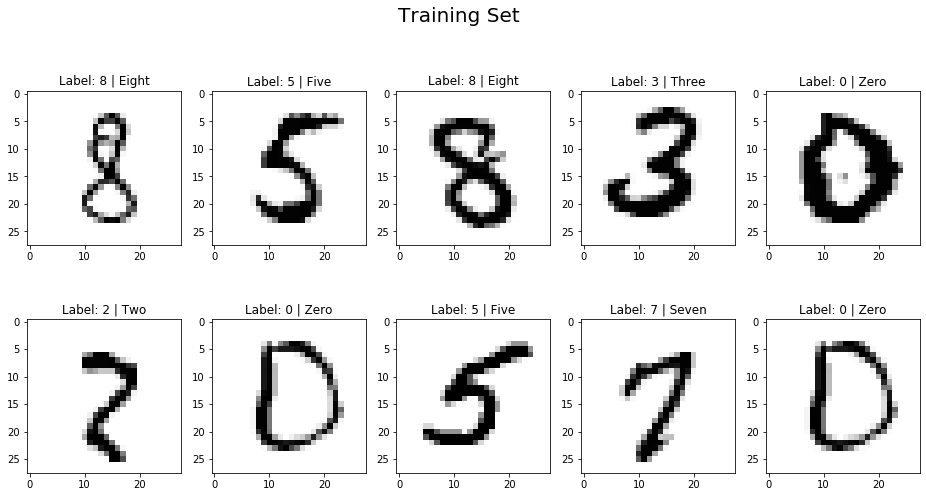

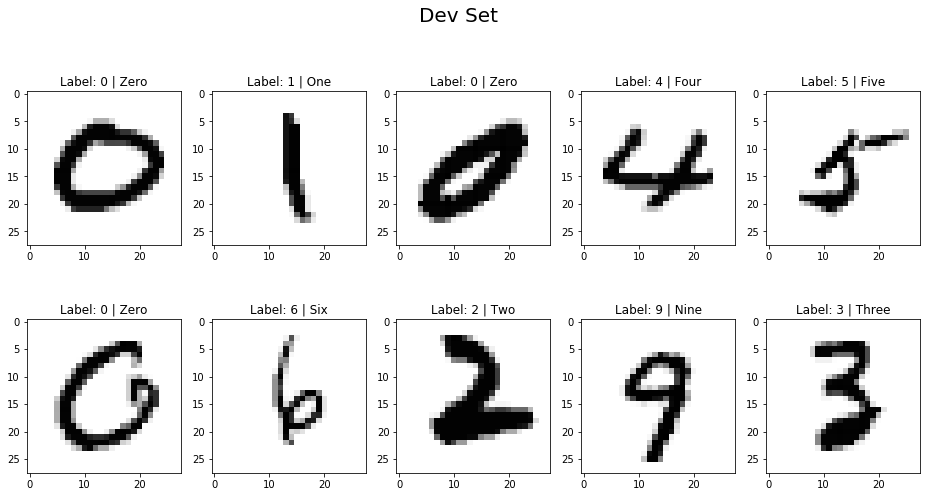

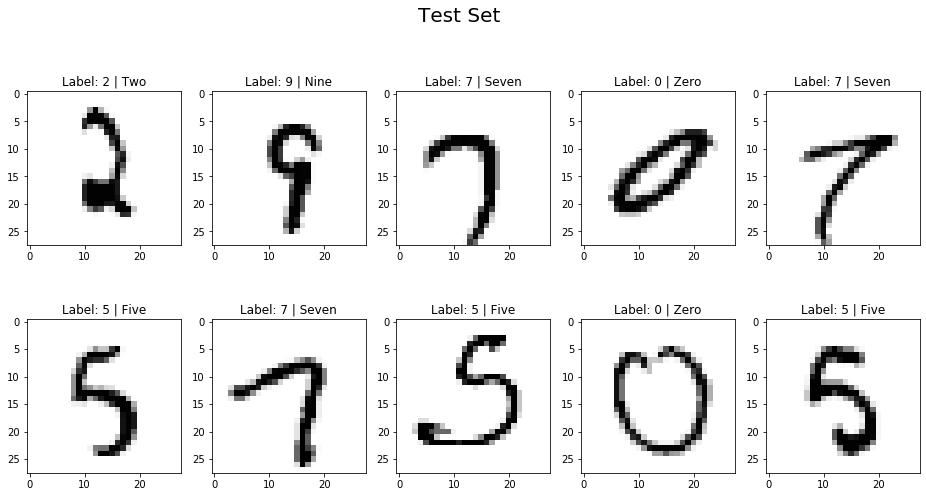

In [18]:
visualize_dataset(train_x_split, train_y_split, dataset = "mnist", dataset_type = "training")
visualize_dataset(dev_x_split, dev_y_split, dataset = "mnist", dataset_type = "dev")
visualize_dataset(test_x_orig, test_y_orig, dataset = "mnist", dataset_type="test")

# Preparing Dataset

## Flattening the images

In [19]:
def flatten_input(x_orig):
    """Returns the flattened 2D array of input images
        
        Arguement:
            x_orig (numpy.ndarray): 3D numpy array of the input set images of size (m,28,28)
            
        Returns:
            x_flatten (numpy.ndarray): 2D numpy array of flattened input data of size (784,m)
            
        Example:
            >>> train_x_flatten = flatten_input(train_x)
    """
    m = x_orig.shape[0] #number of examples in dataset set
    
    #flattening the image--The "-1" makes reshape flatten the remaining dimensions
    x_flatten = x_orig.reshape(x_orig.shape[0], -1).T   

    assert(x_flatten.shape == (784,m) )
    
    return x_flatten

In [20]:
train_x_flatten = flatten_input(train_x_split)
dev_x_flatten = flatten_input(dev_x_split)
test_x_flatten = flatten_input(test_x_orig)

print("Data\t\t\t","Shape")
print("=====================================")
print ("Input Training set:\t" + str(train_x_flatten.shape))
print ("Input Dev set:\t\t" + str(dev_x_flatten.shape))
print ("Input Test set:\t\t" + str(test_x_flatten.shape))
print("=====================================")

Data			 Shape
Input Training set:	(784, 50000)
Input Dev set:		(784, 10000)
Input Test set:		(784, 10000)


## Normalizing the images

In [21]:
def normalize_input(x_flatten):
    """Normalizes the pixel values of the flattened images to the range 0-1
        
        Arguement:
            x_flatten (numpy.ndarray): flattened input data of size (784,m)

        Returns:
            x_norm (numpy.ndarray): normalized input data of size (784,m)
            
        Example:
            >>> train_x_norm = normalize_input(train_x_flatten)
    """
    m = x_flatten.shape[1]
    
    # Normalizing the data into the range between 0 and 1.
    x_norm = np.divide(x_flatten,255.)
    
    assert(x_norm.shape == (784,m) )
    
    return x_norm

In [22]:
train_x_norm = normalize_input(train_x_flatten)
dev_x_norm= normalize_input(dev_x_flatten)
test_x_norm = normalize_input(test_x_flatten)

print("Data\t\t\t","Shape")
print("=====================================")
print ("Input Training set:\t" + str(train_x_norm.shape))
print ("Input Dev set:\t\t" + str(dev_x_norm.shape))
print ("Input Test set:\t\t" + str(test_x_norm.shape))
print("=====================================")

Data			 Shape
Input Training set:	(784, 50000)
Input Dev set:		(784, 10000)
Input Test set:		(784, 10000)


## Encoding the labels

In [23]:
def one_hot_encoding(y_orig, num_class):
    """Transform the output labels into the one-hot encoding representation
        
        Arguments:
            y_orig (numpy.ndarray): numeric labels(decimal form) loaded directly from the binary file of size (1,m)
            num_class (int): number of the classes of the labels
        Returns:
            y_encoded (numpy.ndarray): encoded ndarray of the labels with binary values of size (num_class,m)
            
        Example:
            >>> train_y_encoded = one_hot_encoding(train_y.T, num_class = 10)
    """
    m = y_orig.shape[1]
    #encoding the labels
    y_encoded = np.eye(num_class)[y_orig.reshape(-1)].T


    assert(y_encoded.shape == (num_class, m))
    return y_encoded

In [24]:
toc = time.time()
#encoding the output of the training and the test dataset
train_y_encoded = one_hot_encoding(train_y_split.T, num_class = 10 )
dev_y_encoded = one_hot_encoding(dev_y_split.T, num_class = 10)
test_y_encoded = one_hot_encoding(test_y_orig.T, num_class = 10)
tic = time.time()
print("Time to encode: " + str(1000*(tic-toc)) + " ms\n")

print("Data\t\t\t","Shape")
print("===================================")
print ("Output Training set:\t" + str(train_y_encoded.shape))
print ("Output Dev set:\t\t" + str(dev_y_encoded.shape))
print ("Output Test set:\t" + str(test_y_encoded.shape))
print("===================================")

Time to encode: 1.5294551849365234 ms

Data			 Shape
Output Training set:	(10, 50000)
Output Dev set:		(10, 10000)
Output Test set:	(10, 10000)


## Prep Dataset

In [25]:
def prep_dataset(x_orig, y_orig, num_class = 10):
    """Flatten and Normalize the input images and encode the output labels to one-hot representation.
        
        Arguments:
            x_orig (numpy.ndarray): input images of size (60000,28,28)
            y_orig (numpy.ndarray): input labels of size (60000,1)
            num_class(int, optional): number of the classes of the labels. Defaults to 10
            
        Returns:
            x_norm (numpy.ndarray): flattened and normalized input data
            y_encoded (numpy.ndarray): labels encoded in one-hot representation
            
        Example:
            >>> train_x_norm, train_y_encoded = prep_dataset(train_x, train_y, num_class = 10)
    """
    #flatten the input images
    x_flatten = flatten_input(x_orig)
    
    #normalize the input images
    x_norm = normalize_input(x_flatten)
    
    #encode the output labels
    y_encoded = one_hot_encoding(y_orig.T, num_class)
    
    return x_norm,y_encoded

In [26]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(50000, 28, 28)		(784, 50000)
Training Set Labels:	(50000, 1)		(10, 50000)
Dev Set Images:		(10000, 28, 28)		(784, 10000)
Dev Set Labels:		(10000, 1)		(10, 10000)
Test Set Images:	(10000, 28, 28)		(784, 10000)
Test Set Labels:	(10000, 1)		(10, 10000)


### Further Work
- [ ] Optimize the code using comprehension techniques
- [x] Make sure the code is clean and understandable. Follow a single naming convention and give proper name for all the variables
- [x] Write the method description as detailed as possible with proper examples
- [x] Generate the Documentation